<a href="https://colab.research.google.com/github/arunravi8595/CE888_Assignment_2/blob/main/UK_police_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [279]:
#Import required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Data exploration**


In [280]:
#To find ethnicity distribution in Stop & Search by Police
#Data downloaded from https://data.police.uk/data/
Police_search = pd.read_csv('https://raw.githubusercontent.com/arunravi8595/CE888/main/Assignment/2020-12-essex-stop-and-search.csv') 
Police_search.head()

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Person and Vehicle search,2020-12-01T00:01:00+00:00,False,NaN,51.881413,0.215455,Female,25-34,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Articles for use in criminal damage,A no further action disposal,False,False
1,Person search,2020-12-01T00:01:00+00:00,False,NaN,51.636110,0.062590,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False
2,Person search,2020-12-01T00:01:00+00:00,False,NaN,51.636546,0.063333,Male,18-24,Black/African/Caribbean/Black British - Caribbean,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False
3,Person search,2020-12-01T01:01:00+00:00,False,NaN,51.629479,0.439730,Male,18-24,Other ethnic group - Not stated,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False
4,Vehicle search,2020-12-01T01:01:00+00:00,False,NaN,51.629479,0.439730,NaN,NaN,NaN,NaN,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,NaN


In [281]:
Police_search.shape

(422, 15)

In [282]:
#Check NaN in data
Police_search.isnull().sum()

Type                                          0
Date                                          0
Part of a policing operation                  0
Policing operation                          422
Latitude                                      4
Longitude                                     4
Gender                                       37
Age range                                    45
Self-defined ethnicity                       37
Officer-defined ethnicity                    48
Legislation                                   0
Object of search                              0
Outcome                                       3
Outcome linked to object of search            0
Removal of more than just outer clothing     37
dtype: int64

In [283]:
#Take only the required columns from the dataset

Police_search = Police_search[['Type','Gender','Age range','Officer-defined ethnicity','Outcome','Outcome linked to object of search']]
data = Police_search.dropna()
data = data.reset_index(drop=True)
data.describe()

,Type,Gender,Age range,Officer-defined ethnicity,Outcome,Outcome linked to object of search
count,364,364,364,364,364,364
unique,2,2,4,4,5,2
top,Person search,Male,18-24,White,A no further action disposal,False
freq,287,325,159,294,284,288


**Understanding the field of importance in the data**

To know which part of the data to be checked for bias. Visualising the information from the stop and search can provide a general idea on what part needs to be analyzed.
The main task is to find how ethnicity plays a role in police search. So the information that is related to ethnic distribution is considered.

In [284]:
Police_search["Officer-defined ethnicity"].value_counts()

White    304
Black     46
Asian     12
Other     12
Name: Officer-defined ethnicity, dtype: int64

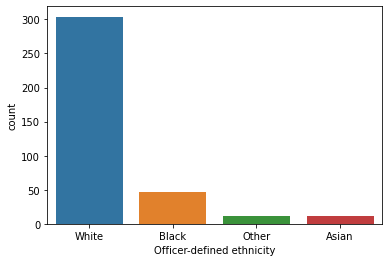

In [285]:
#Plot ethnicity distribution
sns.countplot(x="Officer-defined ethnicity", data = Police_search)

In [286]:
#Combine different Non-white categoriess into a single class

Ethnicity = []
for x in Police_search["Officer-defined ethnicity"]:
  if x == "White":
    y = "White"  
  elif x == "Other":
    y = "Other"
  else:
    y = "Non-White"     
  Ethnicity.append(y)       
  
Police_search["Ethnicity"] = Ethnicity        

In [287]:
Police_search["Ethnicity"].value_counts()

White        304
Non-White    106
Other         12
Name: Ethnicity, dtype: int64

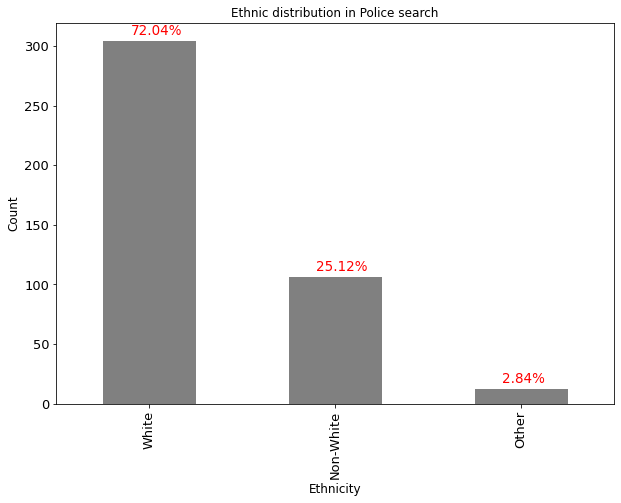

In [288]:
#Plot a graph to visualize the ethnic distribution

graph = Police_search['Ethnicity'].value_counts().plot(kind='bar', figsize=(10,7),
                                                  color="grey", fontsize=13);
graph.set_alpha(0.8)
graph.set_title("Ethnic distribution in Police search", fontsize=12)
graph.set_ylabel('Count', fontsize=12)
graph.set_xlabel('Ethnicity', fontsize=12)

totals = []

# find the values and append to list
for i in graph.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in graph.patches:
    # get_x pulls left or right; get_height pushes up or down
    graph.text(i.get_x()+0.15, i.get_height()+5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=13.5,
                color='red')

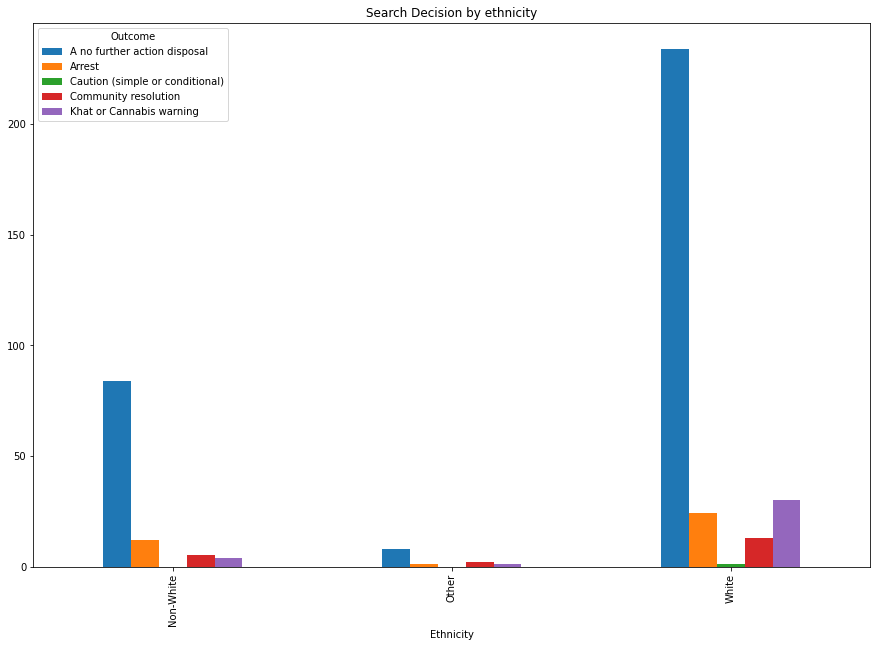

In [289]:
#To find the outcome decision taken by police officers based on ethnicity
Police_search.groupby('Outcome')['Ethnicity'].value_counts().unstack(0).plot.bar(title='Search Decision by ethnicity', figsize=(15,10));

In [290]:
# In the data, "Outcome linked to object of search" specifies whether the suspect has been arrested or not
# Hence the column is renamed as "Arrested" which has the info as TRUE or FALSE
Police_search.rename(columns = {'Outcome linked to object of search':'Arrested'}, inplace = True)
Police_search["Arrested"].value_counts()

False    334
True      88
Name: Arrested, dtype: int64

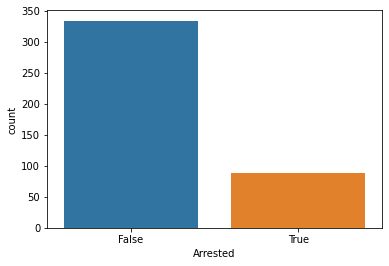

In [291]:
sns.countplot(x = "Arrested", data = Police_search)

In [292]:
Police_search["Gender"].value_counts()

Male      345
Female     40
Name: Gender, dtype: int64

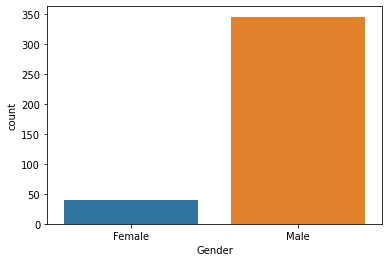

In [293]:
sns.countplot(x = "Gender", data = Police_search)

In [294]:
Police_search['Arrested'].value_counts(normalize=True).mul(100).astype(str)+'%'

False    79.14691943127961%
True     20.85308056872038%
Name: Arrested, dtype: object

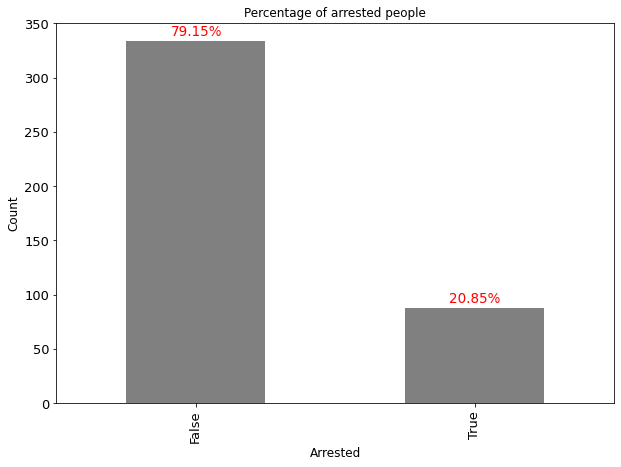

In [295]:
graph = Police_search['Arrested'].value_counts().plot(kind='bar', figsize=(10,7),
                                                  color="grey", fontsize=13);
graph.set_alpha(0.8)
graph.set_title("Percentage of arrested people", fontsize=12)
graph.set_ylabel('Count', fontsize=12)
graph.set_xlabel('Arrested', fontsize=12)

totals = []

# find the values and append to list
for i in graph.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in graph.patches:
    # get_x pulls left or right; get_height pushes up or down
    graph.text(i.get_x()+0.16, i.get_height()+5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=13.5,
                color='red')

In [296]:

census_data = pd.read_csv('https://raw.githubusercontent.com/arunravi8595/CE888/main/Assignment/Essex_Ethnicity_Census.csv') 
census_data.shape

(23, 16)

In [297]:
#Check NaN in data
census_data.isnull().sum()

Category              0
Essex                 0
Basildon              0
Braintree             0
Brentwood             0
Castle Point          0
Chelmsford            0
Colchester            0
Epping Forest         0
Harlow                0
Maldon                0
Rochford              0
Tendring              0
Uttlesford            0
Southend-on-Sea UA    0
Thurrock UA           0
dtype: int64

In [298]:
census_data.head()


,Category,Essex,Basildon,Braintree,Brentwood,Castle Point,Chelmsford,Colchester,Epping Forest,Harlow,Maldon,Rochford,Tendring,Uttlesford,Southend-on-Sea UA,Thurrock UA
0,White: British,1264877,156215,137010,65688,83943,151990,151453,106233,68715,59011,79628,131666,73325,151136,127587
1,White: Irish,11165,1313,1051,921,527,1450,1155,1427,875,358,468,998,622,1496,1108
2,White: Gypsy or Irish Traveller,2161,873,132,121,17,212,79,176,117,201,49,62,122,162,308
3,White: Other White,35653,3276,3894,2138,786,4331,6619,5033,3292,859,792,1941,2692,6229,6426
4,Mixed/multiple ethnic group: White and Black C...,6936,1131,554,343,346,854,889,881,654,152,296,595,241,1039,1056


In [299]:
list(census_data.columns.values)

['Category',
 'Essex ',
 'Basildon',
 'Braintree',
 'Brentwood',
 'Castle Point',
 'Chelmsford',
 'Colchester',
 'Epping Forest',
 'Harlow',
 'Maldon',
 'Rochford',
 'Tendring',
 'Uttlesford',
 'Southend-on-Sea UA',
 'Thurrock UA']

In [300]:
census_data.rename(columns = {'Essex ':'Essex'}, inplace = True)
census = census_data[['Category','Essex']]
census.head()

,Category,Essex
0,White: British,1264877
1,White: Irish,11165
2,White: Gypsy or Irish Traveller,2161
3,White: Other White,35653
4,Mixed/multiple ethnic group: White and Black C...,6936


In [301]:
print (census.dtypes)

Category    object
Essex        int64
dtype: object


In [302]:
census['Ethnic_percent'] = 100*census['Essex']/census['Essex'].sum()
display(census)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Category,Essex,Ethnic_percent
0,White: British,1264877,81.444758
1,White: Irish,11165,0.718908
2,White: Gypsy or Irish Traveller,2161,0.139146
3,White: Other White,35653,2.295678
4,Mixed/multiple ethnic group: White and Black C...,6936,0.446605
5,Mixed/multiple ethnic group: White and Black A...,2801,0.180355
6,Mixed/multiple ethnic group: White and Asian,6173,0.397476
7,Mixed/multiple ethnic group: Other Mixed,4975,0.320338
8,Mixed/Multiple Ethnic Group (Total),20885,1.344774
9,Asian/Asian British: Indian,12456,0.802035


In [303]:
census.set_index('Category')

,Essex,Ethnic_percent
Category,,
White: British,1264877,81.444758
White: Irish,11165,0.718908
White: Gypsy or Irish Traveller,2161,0.139146
White: Other White,35653,2.295678
Mixed/multiple ethnic group: White and Black Caribbean,6936,0.446605
Mixed/multiple ethnic group: White and Black African,2801,0.180355
Mixed/multiple ethnic group: White and Asian,6173,0.397476
Mixed/multiple ethnic group: Other Mixed,4975,0.320338
Mixed/Multiple Ethnic Group (Total),20885,1.344774


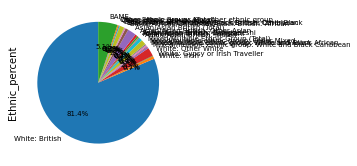

In [304]:
ax1 = plt.subplot(121, aspect='equal')
census.plot(kind='pie', y = 'Ethnic_percent', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=census['Category'], legend = False, fontsize=7)

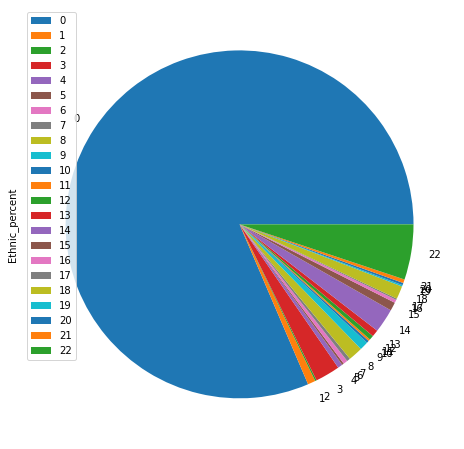

In [305]:
plot = census.plot.pie(y='Ethnic_percent', figsize=(8,8))

In [306]:
#Combine similar ethnic groups together
#Make ethnic classifications to match Data1 - Police search

In [307]:
#Load Data-3
#To find ethnic distribution across the Police workforce
#Data downloaded from https://www.ethnicity-facts-figures.service.gov.uk/workforce-and-business/workforce-diversity/police-workforce/latest#by-ethnicity-police-officers
workforce_data=pd.read_csv('https://raw.githubusercontent.com/arunravi8595/CE888/main/Assignment/by-ethnicity-police-officers-table.csv')
workforce_data.head()

,Ethnicity,% of police officers,% of population,Number of police officers
0,Asian,3.1,6.8,"3,884"
1,Black,1.3,3.3,"1,586"
2,Mixed,2.2,2.2,"2,711"
3,White,92.7,86.0,"1,16,536"
4,Other inc Chinese,0.8,1.7,993


In [308]:
workforce_data.set_index('Ethnicity')

,% of police officers,% of population,Number of police officers
Ethnicity,,,
Asian,3.1,6.8,"3,884"
Black,1.3,3.3,"1,586"
Mixed,2.2,2.2,"2,711"
White,92.7,86.0,"1,16,536"
Other inc Chinese,0.8,1.7,993


In [309]:
list(workforce_data.columns.values)

['Ethnicity',
 '% of police officers',
 '% of population',
 'Number of police officers']

In [310]:
print (workforce_data.dtypes)

Ethnicity                     object
% of police officers         float64
% of population              float64
Number of police officers     object
dtype: object


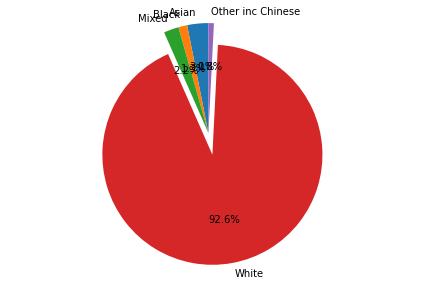

In [311]:
plt.pie(
    workforce_data['% of police officers'],
    labels=workforce_data['Ethnicity'],
    shadow=False,
    explode=(0, 0, 0, 0.2, 0),
    startangle=90,
    autopct='%1.1f%%',
    )
plt.axis('equal')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Pies Consumed')

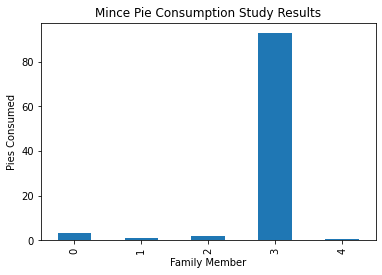

In [312]:
workforce_data['% of police officers'].plot(kind="bar", title="Ethnicity")
plt.title("Mince Pie Consumption Study Results")
plt.xlabel("Family Member")
plt.ylabel("Pies Consumed")

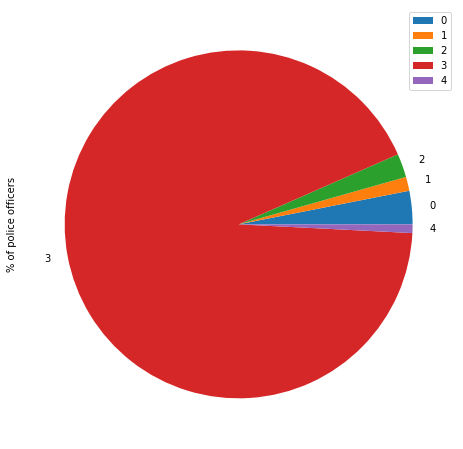

In [313]:
plot = workforce_data.plot.pie(y='% of police officers', figsize=(8,8))

**Detection of Bias and Mitigation**

Using AIF360 ML Algorithm to address the fairness metrics

In [314]:
!pip install 'aif360[all]'
!pip install -U scikit-learn scipy matplotlib
!pip install 'tensorflow>=1.13.1,< 2'
!pip install fairlearn
!pip install BlackBoxAuditing

  Using cached https://files.pythonhosted.org/packages/dc/7e/8f6a79b102ca1ea928bae8998b05bf5dc24a90571db13cd119f275ba6252/scipy-1.5.4-cp37-cp37m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: adversarial-robustness-toolbox 1.6.1 has requirement scikit-learn<=0.24.1,>=0.22.2, but you'll have scikit-learn 0.24.2 which is incompatible.
  Found existing installation: scipy 1.6.3
    Uninstalling scipy-1.6.3:
      Successfully uninstalled scipy-1.6.3


Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)
  Using cached https://files.pythonhosted.org/packages/7d/e8/43ffca541d2f208d516296950b25fe1084b35c2881f4d444c1346ca75815/scipy-1.6.3-cp37-cp37m-manylinux1_x86_64.whl
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.1)
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: aif360 0.4.0 has requirement scipy<1.6.0,>=1.2.0, but you'll have scipy 1.6.3 which is incompatible.
ERROR: adversarial-robustness-toolbox 1.6.1 has requirement scikit-learn<=0.24.1,>=0.22.2, but you'll have scikit-learn 0.24.2 which is incompatible.
  Found existing installation: scipy 1.5.4
    Uninstalling scipy-1.5.4:
      Successfully uninstalled scipy-1.5.4


In [315]:
#importing required library packages:
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

import aif360
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover


from IPython.display import Markdown, display

In [347]:
# Using Police_search data to bulid algorithm and ML model
df = Police_search.copy()
df.head()

,Type,Gender,Age range,Officer-defined ethnicity,Outcome,Arrested,Ethnicity
0,Person and Vehicle search,Female,25-34,White,A no further action disposal,False,White
1,Person search,Female,18-24,White,A no further action disposal,False,White
2,Person search,Male,18-24,Black,A no further action disposal,False,Non-White
3,Person search,Male,18-24,White,A no further action disposal,False,White
4,Vehicle search,NaN,NaN,NaN,A no further action disposal,False,Non-White


In [348]:
df["Ethnicity"].value_counts()

White        304
Non-White    106
Other         12
Name: Ethnicity, dtype: int64

In [349]:
df["Arrested"].value_counts()

False    334
True      88
Name: Arrested, dtype: int64

In [350]:
print (df.dtypes)

Type                         object
Gender                       object
Age range                    object
Officer-defined ethnicity    object
Outcome                      object
Arrested                       bool
Ethnicity                    object
dtype: object


In [351]:
#Replacing boolean values with string
df['Arrested'] = df['Arrested'].replace({True:'Yes', False:'No'})
df.head()

,Type,Gender,Age range,Officer-defined ethnicity,Outcome,Arrested,Ethnicity
0,Person and Vehicle search,Female,25-34,White,A no further action disposal,No,White
1,Person search,Female,18-24,White,A no further action disposal,No,White
2,Person search,Male,18-24,Black,A no further action disposal,No,Non-White
3,Person search,Male,18-24,White,A no further action disposal,No,White
4,Vehicle search,NaN,NaN,NaN,A no further action disposal,No,Non-White


In [352]:
df["Ethnicity"].value_counts()

White        304
Non-White    106
Other         12
Name: Ethnicity, dtype: int64

In [353]:
df = df[df["Ethnicity"]!="Other"]

In [354]:
df["Ethnicity"].value_counts()

White        304
Non-White    106
Name: Ethnicity, dtype: int64

In [355]:
df["Arrested"].value_counts()

No     324
Yes     86
Name: Arrested, dtype: int64

In [356]:
df["Gender"].value_counts()

Male      334
Female     39
Name: Gender, dtype: int64

In [357]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410 entries, 0 to 420
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Type                       410 non-null    object
 1   Gender                     373 non-null    object
 2   Age range                  365 non-null    object
 3   Officer-defined ethnicity  362 non-null    object
 4   Outcome                    407 non-null    object
 5   Arrested                   410 non-null    object
 6   Ethnicity                  410 non-null    object
dtypes: object(7)
memory usage: 25.6+ KB


In [358]:
#Manually encoding ethnicity and arrest columns

df.loc[df.Ethnicity == "White","Ethnicity"] = 1        #Priviliged
df.loc[df.Ethnicity == "Non-White","Ethnicity"] = 0    #Unpriviliged

df.loc[df.Arrested == "Yes","Ethnicity"] = 1        
df.loc[df.Ethnicity == "No","Ethnicity"] = 0        



In [359]:
y = df["Arrested"]

In [360]:
numerical_ft=["Arrested", "Ethnicity"]
scaler = StandardScaler()

In [361]:
from sklearn import preprocessing
categorical_column = ['Arrested', 'Ethnicity', 'Gender']

data_encoded = df.copy(deep=True)
#Use Scikit-learn label encoding to encode character data
lab_enc = preprocessing.LabelEncoder()
for col in categorical_column:
        data_encoded[col] = lab_enc.fit_transform(df[col])
        le_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
        print('Feature', col)
        print('mapping', le_name_mapping)
        

data_encoded.head()

Feature Arrested
mapping {'No': 0, 'Yes': 1}
Feature Ethnicity
mapping {0: 0, 1: 1}
Feature Gender
mapping {'Female': 0, 'Male': 1, nan: 2}


,Type,Gender,Age range,Officer-defined ethnicity,Outcome,Arrested,Ethnicity
0,Person and Vehicle search,0,25-34,White,A no further action disposal,0,1
1,Person search,0,18-24,White,A no further action disposal,0,1
2,Person search,1,18-24,Black,A no further action disposal,0,0
3,Person search,1,18-24,White,A no further action disposal,0,1
4,Vehicle search,2,NaN,NaN,A no further action disposal,0,0


In [362]:
df.loc[df.Ethnicity == "White","Ethnicity"] = 1
df.loc[df.Ethnicity == "Non-White", "Ethnicity"] = 0

df.loc[df.Arrested =="Yes", "Arrested"] = 1
df.loc[df.Arrested =="No", "Arrested"] = 0

In [363]:
df.shape

(410, 7)

In [364]:
categorical_ft = df[df.columns.difference(numerical_ft)] 
categorical_ft = categorical_ft[categorical_ft.columns.difference(["Ethnicity", "Arrested"])]
categorical_columns = categorical_ft.columns.to_list()

for column in categorical_column:
  encode = pd.get_dummies(df[column], prefix = column)
  df = df.drop(column, axis = 1)
  df = df.join(encode)

In [365]:
df.shape

(410, 10)

In [366]:
encoded_df = df.copy()

In [367]:
x = encoded_df.drop(["Type", "Outcome"],axis=1)

In [368]:
y = y.astype('int')

In [369]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [370]:
privileged_groups = [{'Ethnicity': 'White'}]
unprivileged_groups = [{'Ethnicity': 'Non-white'}]
favorable_label = 1 
unfavorable_label = 0

In [371]:

test = x_test.copy()
test['Arrested'] = y_test
test.shape

(123, 9)

In [402]:
arrest_df = test[test["Arrested"] == 1]
priviliged = arrest_df.shape[0]

no_arrest_df = test[test["Arrested"] == 0]
unpriviliged = no_arrest_df.shape[0]

In [403]:
unpriviliged_result = arrest_df[arrest_df["Arrested"] == 1].shape[0]
unprivileged_ratio = unpriviliged_result/unpriviliged

unprivileged_ratio

0.30851063829787234

In [401]:
priviliged_result = no_arrest_df[no_arrest_df["Arrested"] == 0].shape[0]
privileged_ratio = priviliged_result/priviliged

privileged_ratio

3.2413793103448274

In [376]:
Bias = unprivileged_ratio / privileged_ratio
Bias

0.09517881394296063

In [377]:
from sklearn.feature_selection import RFE

classifier = RandomForestClassifier()
rfe = RFE(classifier, 2)             
rfe = rfe.fit(x_train, y_train)

Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


ValueError: ignored

In [378]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [379]:
encoded_df.head()


,Type,Age range,Officer-defined ethnicity,Outcome,Arrested_0,Arrested_1,Ethnicity_0,Ethnicity_1,Gender_Female,Gender_Male
0,Person and Vehicle search,25-34,White,A no further action disposal,1,0,0,1,1,0
1,Person search,18-24,White,A no further action disposal,1,0,0,1,1,0
2,Person search,18-24,Black,A no further action disposal,1,0,1,0,0,1
3,Person search,18-24,White,A no further action disposal,1,0,0,1,0,1
4,Vehicle search,NaN,NaN,A no further action disposal,1,0,1,0,0,0


In [380]:
data_encoded.head()

,Type,Gender,Age range,Officer-defined ethnicity,Outcome,Arrested,Ethnicity
0,Person and Vehicle search,0,25-34,White,A no further action disposal,0,1
1,Person search,0,18-24,White,A no further action disposal,0,1
2,Person search,1,18-24,Black,A no further action disposal,0,0
3,Person search,1,18-24,White,A no further action disposal,0,1
4,Vehicle search,2,NaN,NaN,A no further action disposal,0,0


In [383]:
df = df.dropna()
print(df)

                          Type Age range  ... Gender_Female Gender_Male
0    Person and Vehicle search     25-34  ...             1           0
1                Person search     18-24  ...             1           0
2                Person search     18-24  ...             0           1
3                Person search     18-24  ...             0           1
5                Person search     25-34  ...             0           1
..                         ...       ...  ...           ...         ...
415              Person search     10-17  ...             0           1
416              Person search     25-34  ...             0           1
418              Person search     18-24  ...             0           1
419              Person search     10-17  ...             0           1
420              Person search     18-24  ...             0           1

[352 rows x 10 columns]


In [385]:
df = df.dropna(subset=df.select_dtypes(float).columns, how='all')


In [388]:
import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover


binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=data_encoded,
    label_names=['Arrested'],
    protected_attribute_names=['Arrested'],
    unprivileged_protected_attributes = 0)
di = DisparateImpactRemover(repair_level = 1.0, sensitive_attribute="Arrested")
dataset_transf_train = di.fit_transform(binaryLabelDataset)
transformed = dataset_transf_train.convert_to_dataframe()[0]
transformed

ValueError: ignored

In [382]:
x_trans = transformed.drop(['Arrested'], axis = 1)
y = transformed['Arrested']

model = LogisticRegression(solver='liblinear', class_weight='balanced')
scaler = StandardScaler()
data_std = scaler.fit_transform(x_trans)

x_trans_train,x_trans_test,y_trans_train,y_trans_test = train_test_split(x_trans, y, test_size=0.2, random_state = 0)

NameError: ignored

In [390]:
model.fit(x_train, y_train)

NameError: ignored

In [389]:
y_predict = pd.Series(model.predict(x_test))
y_test = y_trans_test.reset_index(drop=True)
z = pd.concat([y_test, y_predict], axis=1)
z.columns = ['Original', 'Predicted']
z.head()

NameError: ignored

In [422]:
y_predict = model.predict(x_test)
x_test['Arrested'] = y_predict
trans_output = x_test.copy()
trans_output

NotFittedError: ignored

In [392]:
arrested_df = trans_output[trans_output["Arrested"] == 1]
priviliged = arrested_df.shape[0]
no_arrest_df = trans_output[trans_output["Arrested"] == 0]
unprivileged = no_arrest_df.shape[0]

NameError: ignored

In [405]:
unpriviliged_result = no_arrest_df[no_arrest_df["Arrested"] == 0].shape[0]
unprivileged_ratio = unpriviliged_result/unpriviliged
unprivileged_ratio

1.0

In [414]:
priviliged_result = arrest_df[arrest_df["Arrested"] == 1].shape[0]
priviliged_ratio = priviliged_result/priviliged
priviliged_ratio

1.0

In [417]:
bias = unprivileged_ratio/priviliged_ratio
bias

1.0

In [418]:
model = LogisticRegression(solver='liblinear', class_weight='balanced')

In [419]:
model.fit(x_train, y_train)

ValueError: ignored

In [423]:
import matplotlib.pyplot as plt
from sklearn import metrics
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, y_predict))
print("Precision:", metrics.precision_score(y_test, y_predict))
print("Recall:", metrics.recall_score(y_test, y_predict))
print("F1 Score:", metrics.f1_score(y_test, y_predict))

NameError: ignored

In [424]:
y_predict = model.predict(x_test)
x_test['Arrested'] = y_predict
original_output = x_test.copy()
original_output

NotFittedError: ignored

In [425]:
arrest_df = original_output[original_output["Arrested"] == 1]
priviliged = arrest_df.shape[0]

no_arrest = original_output[original_output["Arrested"] == 0]
unpriviliged = no_arrest_df.shape[0]

NameError: ignored

In [436]:
unpriviliged_result = no_arrest_df[no_arrest_df["Arrested"] == 0].shape[0]
unprivileged_ratio = unpriviliged_result/unpriviliged
unprivileged_ratio

1.0

In [435]:
priviliged_result = arrest_df[arrest_df["Arrested"] == 1].shape[0]
priviliged_ratio = priviliged_result/priviliged
priviliged_ratio

1.0

In [437]:
bias = unprivileged_ratio/priviliged_ratio
bias

1.0